# Spam SMS Detection 

### Importing libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pickle
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import cross_val_score



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shromana\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Collection

In [3]:
#Load the dataset
df=pd.read_csv('spam.csv',encoding='latin-1')
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

## Exploratory data analysis

In [4]:
# number of rows and columns in the dataset
df.shape

(5572, 5)

In [5]:
# getting some information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
#Datatypes of each column
df.dtypes

v1            object
v2            object
Unnamed: 2    object
Unnamed: 3    object
Unnamed: 4    object
dtype: object

In [7]:
# Dropping columns
df = df. drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'], axis=1)

In [8]:
# Renaming the columns 
df.rename(columns={'v1':'target','v2':'text'},inplace=True)

In [9]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
#description statistics
df.describe()

,target,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [11]:
#unique values present in target column
df["target"].unique()

array(['ham', 'spam'], dtype=object)

### Check proportion of each class

In [12]:
df['target'].value_counts()

ham     4825
spam     747
Name: target, dtype: int64

ham --> Good sms
spam --> spam sms

### Check for missing values

In [13]:
df.isnull()
df.isnull().sum()

target    0
text      0
dtype: int64

No missing value

### Check for duplicate values

In [14]:
df.duplicated().sum()

403

In [15]:
df=df.drop_duplicates(keep='first')

In [16]:
df.shape

(5169, 2)

In [17]:
#unique values present
df.apply(pd.Series.nunique)

target       2
text      5169
dtype: int64

### Data Visualisation

<Axes: xlabel='target', ylabel='count'>

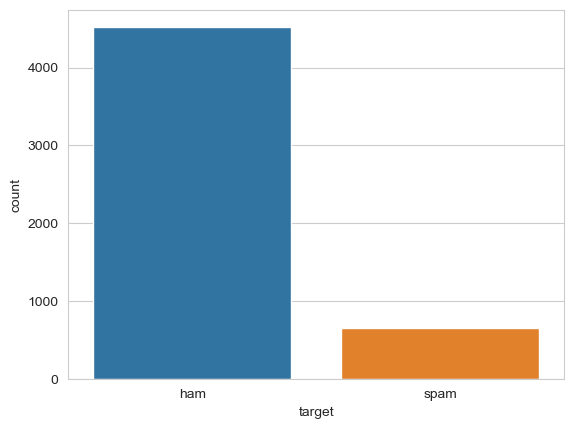

In [18]:
sns.set_style('whitegrid')
sns.countplot(x='target',data=df)

unbalanced dataset

## Label Encoding

In [19]:
# Labelling classes
df['target']=df['target'].map({'ham':0,'spam':1})

In [20]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [21]:
df['num_characters'] = df['text'].apply(len)

In [22]:
df['num_words']=df['text'].apply(lambda x:nltk.word_tokenize(x))

In [23]:
df['num_sentences']=df['text'].apply(lambda x:nltk.sent_tokenize(x))

In [24]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,"[Go, until, jurong, point, ,, crazy, .., Avail...","[Go until jurong point, crazy.., Available onl..."
1,0,Ok lar... Joking wif u oni...,29,"[Ok, lar, ..., Joking, wif, u, oni, ...]","[Ok lar..., Joking wif u oni...]"
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,"[Free, entry, in, 2, a, wkly, comp, to, win, F...",[Free entry in 2 a wkly comp to win FA Cup fin...
3,0,U dun say so early hor... U c already then say...,49,"[U, dun, say, so, early, hor, ..., U, c, alrea...",[U dun say so early hor... U c already then sa...
4,0,"Nah I don't think he goes to usf, he lives aro...",61,"[Nah, I, do, n't, think, he, goes, to, usf, ,,...","[Nah I don't think he goes to usf, he lives ar..."


In [25]:
df.describe()

,target,num_characters
count,5169.000000,5169.000000
mean,0.126330,78.977945
std,0.332253,58.236293
min,0.000000,2.000000
25%,0.000000,36.000000
50%,0.000000,60.000000
75%,0.000000,117.000000
max,1.000000,910.000000


<Axes: xlabel='num_characters', ylabel='Count'>

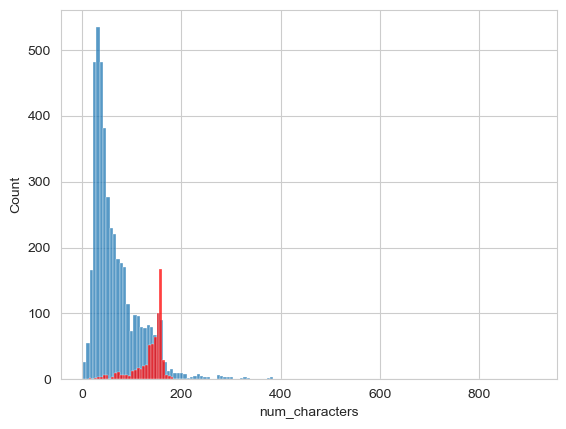

In [26]:
sns.histplot(df[df['target'] ==0]['num_characters'])
sns.histplot(df[df['target'] ==1]['num_characters'],color='red')

## Separating Features and Target

In [27]:
X = df["text"]

In [28]:
#Target
y = df["target"]

## Feature Extraction

In [29]:

cv=CountVectorizer()
X=cv.fit_transform(X)

In [30]:
with open('Vectorizer.pkl','wb') as file:
    pickle.dump(cv,file)

## Data splitting

In [31]:

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Model

In [32]:
 
model=MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [33]:
with open('Spam_SMS_Detection_model_NB.pkl','wb') as file:
    pickle.dump(model,file)

## Cross Validation

In [34]:

scores1=cross_val_score(model,X_train,y_train,cv=10,scoring='accuracy')
scores1

array([0.98067633, 0.97101449, 0.97342995, 0.97342995, 0.98792271,
       0.98062954, 0.97820823, 0.98789346, 0.96610169, 0.98305085])

## Prediction

In [35]:

testing_predict = model.predict(X_test)

## Accuracy

In [36]:

Acc=accuracy_score(testing_predict,y_test)

In [37]:
Acc=Acc*100
print(Acc)

98.25918762088975


The Accuracy is 97%

## Classification Report

In [38]:

report2=classification_report(y_test,testing_predict)
print(report2)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       889
           1       0.94      0.94      0.94       145

    accuracy                           0.98      1034
   macro avg       0.96      0.96      0.96      1034
weighted avg       0.98      0.98      0.98      1034



## Confusion matrix

In [39]:

confusion_matrix=confusion_matrix(y_test,testing_predict)
confusion_matrix

array([[880,   9],
       [  9, 136]], dtype=int64)

## Testing

In [40]:

msg="Hello"
data=[msg]
result=cv.transform(data).toarray()

In [41]:
prediction = model.predict(result)
print(prediction)

[0]


In [42]:
#Testing
msg="Free entry in 2 a wkly comp to win FA Cup final"
data=[msg]
result=cv.transform(data).toarray()

In [43]:
prediction = model.predict(result)
print(prediction)

[1]
